**Important Disclaimer:** Mockup. So far, the example here does not support
fit or predict, let alone hyperparameter tuning etc.

The pipeline shown here assumes the example input tables from
<a href="https://arxiv.org/pdf/1706.00327.pdf#page=3">Fig. 2</a>
of the following paper:
Hoang Thanh Lam, Johann-Michael Thiebaut, Mathieu Sinn, Bei Chen, Tiep Mai, and Oznur Alkan.
"One button machine for automating feature engineering in relational databases". 2017. 
https://arxiv.org/abs/1706.00327

In [1]:
from lale.expressions import it, sum, max, count
import numpy as np

In [2]:
from lale.lib.lale import Scan, Join, Project, GroupBy, Aggregate, ConcatFeatures
from sklearn.feature_selection import SelectKBest as SelectFeatures
from lale.lib.lale import IdentityWrapper as Relational #hack!!
from lale.lib.autoai_libs import NumpyColumnSelector, CatEncoder, OptStandardScaler, FS1
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from xgboost import XGBClassifier as XGBoost
import lale
lale.wrap_imported_operators()

In [3]:
# one-to-one path doesn't need GroupBy >> Aggregate
info_features = (
       (Scan(table=it.main) & Scan(table=it.info))
    >> Join(pred=[it.main.TrainId == it.info.Train_Id, #note the underscore
                  it.main.TimeStamp >= it.info.TimeStamp])
    >> Project(columns=['TrainClass', 'MaxSpeed']))
# one-to-many path (multiple delay rows per main-table row)
delay_features = (
       (Scan(table=it.main) & Scan(table=it.delay))
    >> Join(pred=[it.main.TrainId == it.delay.TrainId,
                  it.main.TimeStamp >= it.delay.TimeStamp])
    >> GroupBy(key=it.MessageId) #primary key of main table
    >> Aggregate(sumDelay=sum(it.Delay), maxDelay = max(it.Delay)))
# multi-hop one-to-many path uses multi-way join
event_features = (
       (Scan(table=it.main) & Scan(table=it.delay) & Scan(table=it.event))
    >> Join(pred=[it.main.TrainId == it.delay.TrainId,
                  it.main.TimeStamp >= it.delay.TimeStamp,
                  it.delay.StationId == it.event.StationId,
                  it.main.TimeStamp >= it.event.TimeStamp])
    >> GroupBy(key=it.MessageId) #primary key of main table
    >> Aggregate(countEvent=count(it.Event)))

In [4]:
all_features = Relational(op=
       (info_features & delay_features & event_features)
    >> ConcatFeatures >> SelectFeatures())

In [5]:
cats_prep = NumpyColumnSelector(columns=[0]) >> CatEncoder(dtype=np.float64)
cont_prep = NumpyColumnSelector(columns=[1,2]) >> OptStandardScaler(use_scaler_flag=True)
all_prep = (cats_prep & cont_prep) >> ConcatFeatures >> FS1(additional_col_count_to_keep=3)

In [6]:
classifier = LR | KNN | XGBoost

In [7]:
pipeline = all_features >> all_prep >> classifier

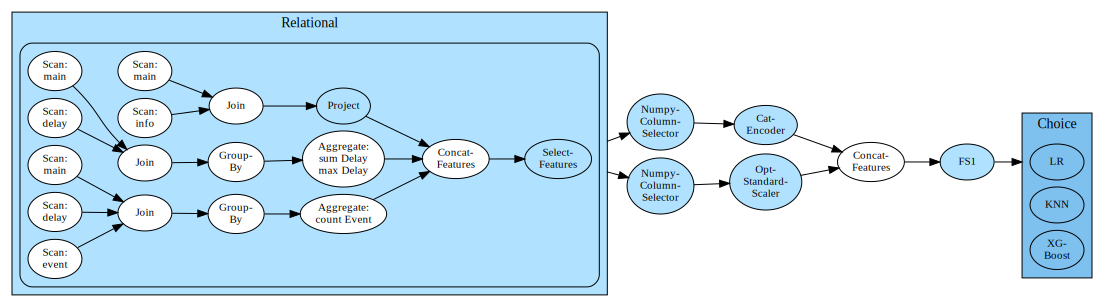

In [8]:
pipeline.visualize()

In [9]:
pipeline.pretty_print(show_imports=False, ipython_display=True)

```python
scan = Scan(table=it.main)
scan_0 = Scan(table=it.info)
join = Join(pred=[(it.main.TrainId == it.info.Train_Id), (it.main.TimeStamp >= it.info.TimeStamp)])
project = Project(columns=['TrainClass', 'MaxSpeed'])
scan_1 = Scan(table=it.main)
scan_2 = Scan(table=it.delay)
join_0 = Join(pred=[(it.main.TrainId == it.delay.TrainId), (it.main.TimeStamp >= it.delay.TimeStamp)])
group_by = GroupBy(key=it.MessageId)
aggregate = Aggregate(sumDelay=sum(it.Delay), maxDelay=max(it.Delay))
scan_3 = Scan(table=it.main)
scan_4 = Scan(table=it.delay)
scan_5 = Scan(table=it.event)
join_1 = Join(pred=[(it.main.TrainId == it.delay.TrainId), (it.main.TimeStamp >= it.delay.TimeStamp), (it.delay.StationId == it.event.StationId), (it.main.TimeStamp >= it.event.TimeStamp)])
group_by_0 = GroupBy(key=it.MessageId)
aggregate_0 = Aggregate(countEvent=count(it.Event))
relational = Relational(op=(((scan & scan_0) >> join >> project) & ((scan_1 & scan_2) >> join_0 >> group_by >> aggregate) & ((scan_3 & scan_4 & scan_5) >> join_1 >> group_by_0 >> aggregate_0)) >> ConcatFeatures >> SelectFeatures())
numpy_column_selector_0 = NumpyColumnSelector(columns=[0])
cat_encoder = CatEncoder(dtype=np.float64)
numpy_column_selector_1 = NumpyColumnSelector(columns=[1, 2])
fs1 = FS1(additional_col_count_to_keep=3)
pipeline = relational >> ((numpy_column_selector_0 >> cat_encoder) & (numpy_column_selector_1 >> OptStandardScaler())) >> ConcatFeatures >> fs1 >> (LR | KNN | XGBoost)
```